### Analyze and Predicting Sun Spots Data using simple DNN

In [2]:
## import libraries

import wget
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
## download data

url = 'https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv'

data = wget.download(url)

100% [..............................................................................] 70827 / 70827

In [9]:
## read data using csv

count = 0
with open(data, newline='') as csvfile:
    file_reader = csv.reader(csvfile)

# read first few lines and check

    for row in file_reader:
        print(row)
        if count >= 5:
            break
        else:
            count+=1

['', 'Date', 'Monthly Mean Total Sunspot Number']
['0', '1749-01-31', '96.7']
['1', '1749-02-28', '104.3']
['2', '1749-03-31', '116.7']
['3', '1749-04-30', '92.8']
['4', '1749-05-31', '141.7']


### Store the data for analysis and prediction
- We will need only the first column i.e. the time series in monthly number and
- Monthly Mean Total Sunspot Number
- All data are in string format, so will need to convert accordingly

In [12]:
data_series = []
time_series = []

with open(data, newline='') as csvfile:
    file_reader = csv.reader(csvfile)
    
    ## skip the first line
    next(file_reader)

    # append the data
    for row in file_reader:
        time_series.append(int(row[0]))   # storing the time series
        data_series.append(float(row[2])) # storing the sunspot number

# convert the data into numpy arrays
data_series = np.array(data_series)
time_series = np.array(time_series)

# print the shape
print(time_series.shape)
print(data_series.shape)

(3235,)
(3235,)


### utility function to plot the data

In [13]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

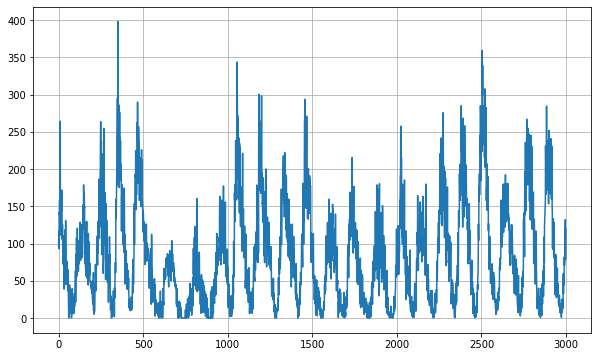

In [16]:
## plot and check

plot_series(train_time, train_series)

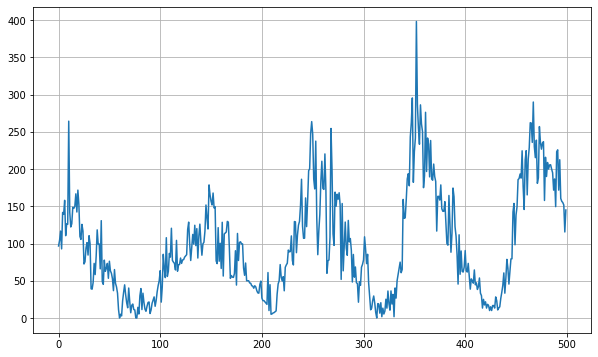

In [17]:
# zoom in and check
plot_series(train_time, train_series, start=0, end=500)

- We can see that around 130-140 units of timesteps (i.e. months) constitutes a full cycle
- that means, around 11 - 12 years
- It is also not very much consistent through out the cycles, but it is forming a general pattern 

### Split the data

In [14]:
split_time = 3000

train_series = data_series[:split_time]
train_time = time_series[:split_time]

valid_series = data_series[split_time:]
valid_time = time_series[split_time:]

# check the shape
print(train_series.shape)
print(valid_series.shape)

(3000,)
(235,)


### generate windowed dataset

In [15]:
# function to generate window dataset

def generate_window_dataset(series, buffer_size, batch_size, window_size):
    
    # generate dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # window
    dataset = dataset.window(size = window_size + 1, shift=1, drop_remainder=True)
    
    # flatten
    dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
    
    # create features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # shuffle
    dataset = dataset.shuffle(buffer_size=buffer_size)
    
    # batch
    dataset = dataset.batch(batch_size=batch_size).prefetch(1)
    
    return dataset
    

In [18]:
## set param values

batch_size = 32
window_size = 30 # keeping around 30 months for window size, we will start with this
buffer_size = 1000

In [19]:
## generate training data

train_data = generate_window_dataset(train_series, buffer_size, batch_size, window_size)

In [21]:
# check the train data

for data in train_data.take(1):
    print('feature shape : {}'.format(data[0].shape))
    print('label shape :{}'.format(data[1].shape))

feature shape : (32, 30)
label shape :(32,)


### Build Model

In [28]:
# clear the session data
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    # using only Dense layers
    tf.keras.layers.Dense(30, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation ='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [29]:
## set up the learning rate parameter

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10 ** (epoch/window_size))

# compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
             loss=tf.keras.losses.Huber(),
             metrics = ['mae'])

# fit the model
model.fit(train_data, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 10s 100ms/step - loss: 137.1999 - mae: 137.6997 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 0s 3ms/step - loss: 136.1878 - mae: 136.6876 - lr: 1.0798e-08
Epoch 3/100
93/93 [==============================] - 0s 3ms/step - loss: 135.1059 - mae: 135.6057 - lr: 1.1659e-08
Epoch 4/100
93/93 [==============================] - 0s 3ms/step - loss: 133.9651 - mae: 134.4649 - lr: 1.2589e-08
Epoch 5/100
93/93 [==============================] - 0s 3ms/step - loss: 132.7612 - mae: 133.2611 - lr: 1.3594e-08
Epoch 6/100
93/93 [==============================] - 0s 3ms/step - loss: 131.4955 - mae: 131.9954 - lr: 1.4678e-08
Epoch 7/100
93/93 [==============================] - 0s 3ms/step - loss: 130.1664 - mae: 130.6663 - lr: 1.5849e-08
Epoch 8/100
93/93 [==============================] - 0s 3ms/step - loss: 128.7707 - mae: 129.2706 - lr: 1.7113e-08
Epoch 9/100
93/93 [==============================] - 0s 3ms/step - loss: 127.

93/93 [==============================] - 0s 3ms/step - loss: 19.3346 - mae: 19.8282 - lr: 2.3263e-06
Epoch 73/100
93/93 [==============================] - 0s 3ms/step - loss: 19.2139 - mae: 19.7059 - lr: 2.5119e-06
Epoch 74/100
93/93 [==============================] - 0s 3ms/step - loss: 19.0787 - mae: 19.5714 - lr: 2.7123e-06
Epoch 75/100
93/93 [==============================] - 0s 3ms/step - loss: 18.9885 - mae: 19.4808 - lr: 2.9286e-06
Epoch 76/100
93/93 [==============================] - 0s 3ms/step - loss: 18.8667 - mae: 19.3585 - lr: 3.1623e-06
Epoch 77/100
93/93 [==============================] - 0s 3ms/step - loss: 18.7969 - mae: 19.2899 - lr: 3.4145e-06
Epoch 78/100
93/93 [==============================] - 0s 3ms/step - loss: 18.6384 - mae: 19.1317 - lr: 3.6869e-06
Epoch 79/100
93/93 [==============================] - 0s 3ms/step - loss: 18.7180 - mae: 19.2096 - lr: 3.9811e-06
Epoch 80/100
93/93 [==============================] - 0s 3ms/step - loss: 18.4061 - mae: 18.8986 - lr

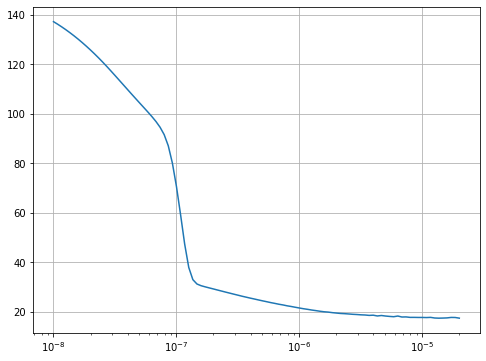

In [31]:
## plot the loss against the learning rate

metrics = pd.DataFrame(model.history.history)
metrics

plt.figure(figsize=(8,6))
plt.semilogx(metrics['lr'], metrics['loss'])
plt.grid(True)
plt.show()

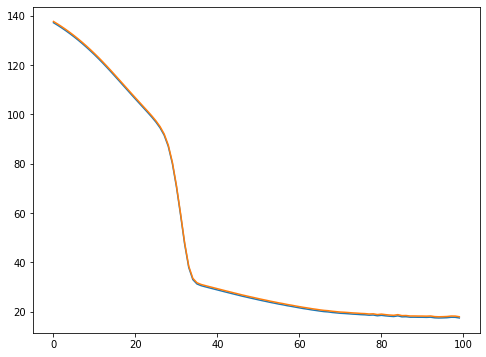

In [32]:
## plot the loss and the mae as per epoch

epoch_range = range(100)
plt.figure(figsize=(8,6))
plt.plot(epoch_range, metrics['loss'])
plt.plot(epoch_range, metrics['mae'])
plt.show()

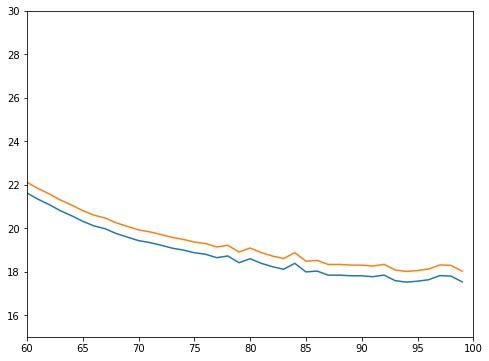

In [36]:
## plot the loss and the mae as per epoch

epoch_range = range(100)
plt.figure(figsize=(8,6))
plt.plot(epoch_range, metrics['loss'])
plt.plot(epoch_range, metrics['mae'])
plt.axis([60,100,15,30])
plt.show()

In [37]:
## Re-train the model again

# clear the session data
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    # using only Dense layers
    tf.keras.layers.Dense(30, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation ='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [38]:
## set up the learning rate parameter

learning_rate = 1e-5

# compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
             loss=tf.keras.losses.Huber(),
             metrics = ['mae'])

# fit the model
model.fit(train_data, epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 3ms/step - loss: 48.7629 - mae: 49.2584
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 23.3268 - mae: 23.8207
Epoch 3/100
93/93 [==============================] - 0s 3ms/step - loss: 20.3621 - mae: 20.8554
Epoch 4/100
93/93 [==============================] - 0s 3ms/step - loss: 19.4990 - mae: 19.9917
Epoch 5/100
93/93 [==============================] - 0s 3ms/step - loss: 19.2216 - mae: 19.7148
Epoch 6/100
93/93 [==============================] - 0s 3ms/step - loss: 18.7520 - mae: 19.2442
Epoch 7/100
93/93 [==============================] - 0s 3ms/step - loss: 18.6083 - mae: 19.1001
Epoch 8/100
93/93 [==============================] - 0s 3ms/step - loss: 18.4349 - mae: 18.9269
Epoch 9/100
93/93 [==============================] - 0s 3ms/step - loss: 18.3067 - mae: 18.7992
Epoch 10/100
93/93 [==============================] - 0s 3ms/step - loss: 18.1409 - mae: 18.6329
Epoch 11/100
93/93 [===================

93/93 [==============================] - 0s 3ms/step - loss: 16.9041 - mae: 17.3965
Epoch 86/100
93/93 [==============================] - 0s 3ms/step - loss: 16.8881 - mae: 17.3794
Epoch 87/100
93/93 [==============================] - 0s 3ms/step - loss: 16.8659 - mae: 17.3565
Epoch 88/100
93/93 [==============================] - 0s 3ms/step - loss: 16.8761 - mae: 17.3680
Epoch 89/100
93/93 [==============================] - 0s 3ms/step - loss: 16.8803 - mae: 17.3726
Epoch 90/100
93/93 [==============================] - 0s 3ms/step - loss: 16.8552 - mae: 17.3469
Epoch 91/100
93/93 [==============================] - 0s 3ms/step - loss: 16.8269 - mae: 17.3186
Epoch 92/100
93/93 [==============================] - 0s 3ms/step - loss: 16.8376 - mae: 17.3287
Epoch 93/100
93/93 [==============================] - 0s 3ms/step - loss: 17.0329 - mae: 17.5244
Epoch 94/100
93/93 [==============================] - 0s 3ms/step - loss: 16.7048 - mae: 17.1963
Epoch 95/100
93/93 [=======================

### Validate using the validation data

In [39]:
## function to generate prediction

def get_predictions(model, series, batch_size, window_size):
    
    # generate dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # window
    dataset = dataset.window(size = window_size, shift=1, drop_remainder=True)
    
    # flatten
    dataset = dataset.flat_map(lambda window:window.batch(window_size))

    # batch
    dataset = dataset.batch(batch_size=batch_size).prefetch(1)
    
    # predict
    predictions = model.predict(dataset)
    
    return predictions

In [40]:
## set up and create validation data for prediction

forecast_data = data_series[split_time - window_size : -1]

forecasts = get_predictions(model, forecast_data, batch_size, window_size)

print(forecasts.shape)

8/8 [==============================] - 0s 6ms/step
(235, 1)


In [42]:
results = forecasts.squeeze()

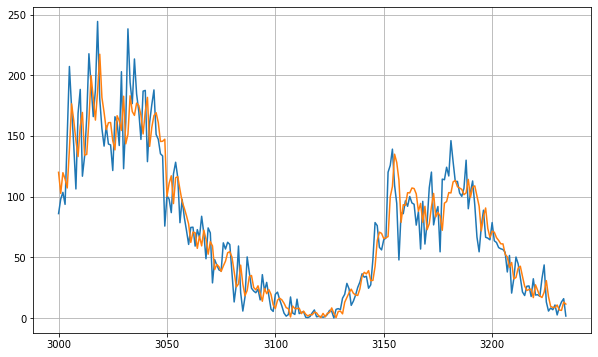

In [43]:
## plot

plot_series(valid_time, (valid_series, results))

In [44]:
## get metrics

print('Mean Squared Error: {}'.format(tf.keras.metrics.mean_squared_error(valid_series, results).numpy()))
print('Mean Absolute Error: {}'.format(tf.keras.metrics.mean_absolute_error(valid_series, results).numpy()))

Mean Squared Error: 439.57659912109375
Mean Absolute Error: 14.619105339050293


In [45]:
data_series.mean()

82.48108191653786